In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
try:
    from langgraph.checkpoint.memory import MemorySaver
    HAS_MEMORY = True
except ImportError:
    HAS_MEMORY = False
    print("⚠️  Memory checkpointing not available, running without persistence")

# Define the state structure
class State(TypedDict):
    messages: list
    user_feedback: str
    needs_approval: bool

# Node functions
def initial_processing(state: State):
    """Initial processing node that generates a draft response"""
    print("🤖 Processing your request...")
    
    # Simulate some processing
    draft_response = "I think the best approach would be to implement a REST API with authentication."
    
    # Simple message append instead of using add_messages
    messages = state.get("messages", [])
    messages.append({"role": "assistant", "content": f"Draft: {draft_response}"})
    
    return {
        "messages": messages,
        "needs_approval": True
    }

def human_review(state: State):
    """Human review node - this is where we pause for user input"""
    print("\n⏸️  HUMAN REVIEW REQUIRED")
    print("Draft response:", state["messages"][-1]["content"])
    print("\nOptions:")
    print("1. Approve (type 'approve')")
    print("2. Request changes (type your feedback)")
    print("3. Reject (type 'reject')")
    
    user_input = input("\nYour decision: ").strip()
    
    return {
        "user_feedback": user_input,
        "needs_approval": False
    }

def process_feedback(state: State):
    """Process the human feedback and decide next steps"""
    feedback = state["user_feedback"].lower()
    
    if feedback == "approve":
        return {
            "messages": [{"role": "assistant", "content": "✅ Response approved and finalized!"}]
        }
    elif feedback == "reject":
        return {
            "messages": [{"role": "assistant", "content": "❌ Response rejected. Task cancelled."}]
        }
    else:
        # User provided specific feedback
        revised_response = f"Revised based on feedback '{state['user_feedback']}': I'll adjust the approach to better meet your requirements."
        return {
            "messages": [{"role": "assistant", "content": revised_response}],
            "needs_approval": True  # May need another review
        }

def should_continue(state: State):
    """Conditional edge function to determine next step"""
    if state.get("needs_approval", False):
        return "human_review"
    else:
        feedback = state.get("user_feedback", "").lower()
        if feedback in ["approve", "reject"]:
            return "end"
        else:
            return "human_review"  # Need another review after revision

# Create the graph
def create_human_loop_graph():
    # Initialize the graph
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("initial_processing", initial_processing)
    workflow.add_node("human_review", human_review)
    workflow.add_node("process_feedback", process_feedback)
    
    # Add edges
    workflow.add_edge(START, "initial_processing")
    workflow.add_edge("initial_processing", "human_review")
    workflow.add_edge("human_review", "process_feedback")
    
    # Add conditional edge
    workflow.add_conditional_edges(
        "process_feedback",
        should_continue,
        {
            "human_review": "human_review",
            "end": END
        }
    )
    
    # Add memory to persist state (if available)
    if HAS_MEMORY:
        memory = MemorySaver()
        app = workflow.compile(checkpointer=memory)
    else:
        app = workflow.compile()
    
    return app



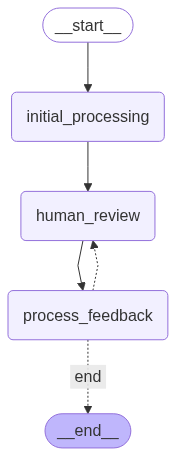

In [2]:
# In a Jupyter cell
from IPython.display import Image, display

# Create your graph
app = create_human_loop_graph()

# Display the graph
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Example usage
def run_example():
    print("🚀 Starting Human-in-the-Loop Example\n")
    
    # Create the graph
    app = create_human_loop_graph()
    
    # Initial state
    initial_state = {
        "messages": [{"role": "user", "content": "Help me design a web application"}],
        "user_feedback": "",
        "needs_approval": False
    }
    
    # Configuration for thread management
    config = {"configurable": {"thread_id": "example_thread"}}
    
    # Run the graph
    try:
        final_state = None
        for output in app.stream(initial_state, config):
            for key, value in output.items():
                print(f"\n--- {key.upper()} ---")
                if "messages" in value and value["messages"]:
                    print(f"Latest message: {value['messages'][-1]['content']}")
                final_state = value
        
        print(f"\n🎉 Final Result: {final_state}")
        
    except KeyboardInterrupt:
        print("\n\n⏹️  Process interrupted by user")
    except Exception as e:
        print(f"\n❌ Error: {e}")

if __name__ == "__main__":
    # Install required packages first:
    # pip install langgraph langchain-core
    
    run_example()

🚀 Starting Human-in-the-Loop Example

🤖 Processing your request...

--- INITIAL_PROCESSING ---
Latest message: Draft: I think the best approach would be to implement a REST API with authentication.

⏸️  HUMAN REVIEW REQUIRED
Draft response: Draft: I think the best approach would be to implement a REST API with authentication.

Options:
1. Approve (type 'approve')
2. Request changes (type your feedback)
3. Reject (type 'reject')



--- HUMAN_REVIEW ---

--- PROCESS_FEEDBACK ---
Latest message: Revised based on feedback 'dont proceed': I'll adjust the approach to better meet your requirements.

⏸️  HUMAN REVIEW REQUIRED
Draft response: Revised based on feedback 'dont proceed': I'll adjust the approach to better meet your requirements.

Options:
1. Approve (type 'approve')
2. Request changes (type your feedback)
3. Reject (type 'reject')

--- HUMAN_REVIEW ---

--- PROCESS_FEEDBACK ---
Latest message: Revised based on feedback 'not happy': I'll adjust the approach to better meet your requirements.

⏸️  HUMAN REVIEW REQUIRED
Draft response: Revised based on feedback 'not happy': I'll adjust the approach to better meet your requirements.

Options:
1. Approve (type 'approve')
2. Request changes (type your feedback)
3. Reject (type 'reject')

--- HUMAN_REVIEW ---

--- PROCESS_FEEDBACK ---
Latest message: ✅ Response approved and finalized!

🎉 Final Result: {'messages': [{'role': 'assistant', 'content': '✅ Response appro